In [1]:
"""
Due to the large data files loaded in the modules during imports, this cell takes a while to run
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

import scipy.sparse as sparse
from sklearn.metrics import mean_squared_error
import os
import sys
import pickle
import itertools

sys.path.append('Models')

import wrmf, wrmf_helpers
from settings import PATH_TO_SPARSE_MATRIX


import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

from evaluation import get_model_clickscore

# NOTE: 

Before you run this notebook, make sure you have the following files in your "data" folder (downloaded from drive): 
1. mdp_wrmf_sparse_matrix_800.pickle
2. wrmf_factors.pickle
3. stage_2_val.pickle
4. stage_2_train.pickle
5. spotify_dictionary.pickle

# 1. WRMF and stage 1 

## (1.1) Compute the wrmf factors 

In [2]:
"""
NOTE: ONLY RUN THIS IF YOU WANT TO RECOMPUTE WRMF WITH NEW PARAMS.
OTHERWISE USE PRECOMPUTED FACTORIZATION (STORED LOCALLY/IN DRIVE)
"""
# params = {
#     'factors': 20,
#     'reg': 0.1,
#     'iters': 20,
#     'alpha': 15
# }
# song_factors = get_wrmf_factors.get_fitted_wrmf(PATH_TO_SPARSE_MATRIX, params)

'\nNOTE: ONLY RUN THIS IF YOU WANT TO RECOMPUTE WRMF WITH NEW PARAMS.\nOTHERWISE USE PRECOMPUTED FACTORIZATION (STORED LOCALLY/IN DRIVE)\n'

## (1.2) Get the song factorization 

In [3]:
with open('data/wrmf_factors.pickle', 'rb') as f:
    playlist_factors, song_factors = pickle.load(f)

print(song_factors.shape)
print(playlist_factors.shape)

(2029866, 20)
(800000, 20)


## (1.3) Example: get "n_similar" top songs for random seed songs 

In [4]:
# example: It Wasn't Me, by Shaggy and Ignition - Remix
song_ids = ['1lzr43nnXAijIGYnCT8M8H', '5dNfHmqgr128gMY2tc5CeJ']
top_matches = wrmf_helpers.get_top_similar_from_tracks(song_factors, song_ids, n_similar=10, verbose=True)


Recommended Songs for ["It Wasn't Me", 'Ignition - Remix']
------------------------------------------------------------
Track Name                                        Score
------------------------------------------------------------
Ignition - Remix                                  0.988374
It Wasn't Me                                      0.986951
Ride Wit Me                                       0.943358
Buy U a Drank (Shawty Snappin') (feat. Yung Joc)  0.928722
Playin' the Game                                  0.928006
Gold Digger                                       0.919052
Remix to Ignition                                 0.913630
Angel                                             0.910224
Yeah!                                             0.909689
Suga Suga                                         0.907704


## (1.4) Example: get "n_similar" top songs for seed from actual test playlist

In [5]:
filename = '/Users/mabasta/Desktop/CS109a/playlist-generation/data/Songs/songs501.csv'
cols_ignore = ['pos', 'artist_name', 'artist_uri', 'track_name', 'album_uri', 'duration_ms', 'album_name']
df = pd.read_csv(filename).drop(columns = cols_ignore)

In [6]:
# print out the playlist
sample_playlists = [group.track_uri for _, group in df.groupby('pid')]
test_playlist = sample_playlists[0]
test_playlist = test_playlist.str.replace('spotify:track:', '')

for tid in test_playlist:
    print(wrmf_helpers.get_song_name(tid))

My Girl (feat. T. Gatez)
New Religion
Broad Shoulders (feat. Chance the Rapper)
Free
She Moves In Her Own Way
Don't Take the Money
that one song
Lovely
Always Like This
Twice
Caroline
Never Seen Anything "Quite Like You"
Sunshine & Kool-Aid
No Such Thing
Heart's Content
Smoke and Mirrors
Best For Last
90210 (feat. G-Eazy)
Spaces
Milk & Honey
Don't Dream It's Over
Lover Come Back
A Dream Is A Wish Your Heart Makes


In [7]:
# get similar using song to song
seed_ids = list(test_playlist[:2])
top_matches = wrmf_helpers.get_top_similar_from_tracks(
    song_factors,
    seed_ids,
    n_similar=20000,
    verbose=False
)
overlaps = set(test_playlist).intersection(set(top_matches))
print(f"Found {len(overlaps)} overlaps:")
for overlap in overlaps:
    print(wrmf_helpers.get_song_name(overlap))

Found 9 overlaps:
Free
My Girl (feat. T. Gatez)
A Dream Is A Wish Your Heart Makes
Milk & Honey
Sunshine & Kool-Aid
Lovely
Caroline
New Religion
that one song


In [8]:
# get similar using playlist to song
top_matches = wrmf_helpers.get_top_similar_from_playlists(
    song_factors,
    playlist_factors,
    seed_ids,
    n_similar_songs=20000,
    n_similar_playlists=200
)
overlaps = set(test_playlist).intersection(set(top_matches))
print(f"Found {len(overlaps)} overlaps:")
for overlap in overlaps:
    print(wrmf_helpers.get_song_name(overlap))

Found 14 overlaps:
Lover Come Back
My Girl (feat. T. Gatez)
Twice
Milk & Honey
She Moves In Her Own Way
Sunshine & Kool-Aid
No Such Thing
Broad Shoulders (feat. Chance the Rapper)
Caroline
New Religion
that one song
90210 (feat. G-Eazy)
Smoke and Mirrors
Always Like This


In [9]:
# get similar using ensemble playlist and song

top_matches = wrmf_helpers.get_top_similar_from_ensemble(
    song_factors,
    playlist_factors,
    seed_ids,
    n_similar_songs=20000,
    n_similar_playlists=200
)
overlaps = set(test_playlist).intersection(set(top_matches))
print(f"Found {len(overlaps)} overlaps:")
for overlap in overlaps:
    print(wrmf_helpers.get_song_name(overlap))

Found 16 overlaps:
Lover Come Back
My Girl (feat. T. Gatez)
Twice
Milk & Honey
She Moves In Her Own Way
Sunshine & Kool-Aid
No Such Thing
Never Seen Anything "Quite Like You"
Broad Shoulders (feat. Chance the Rapper)
Caroline
Heart's Content
New Religion
that one song
90210 (feat. G-Eazy)
Smoke and Mirrors
Always Like This


## (1.5) Visualizations

In [10]:
output_sizes = [500, 1000, 5000, 10000, 15000, 20000, 30000]

with open('data/wrmf_models_results.pickle', 'rb') as f:
    song_to_song, playlist_to_song, ensemble = pickle.load(f)

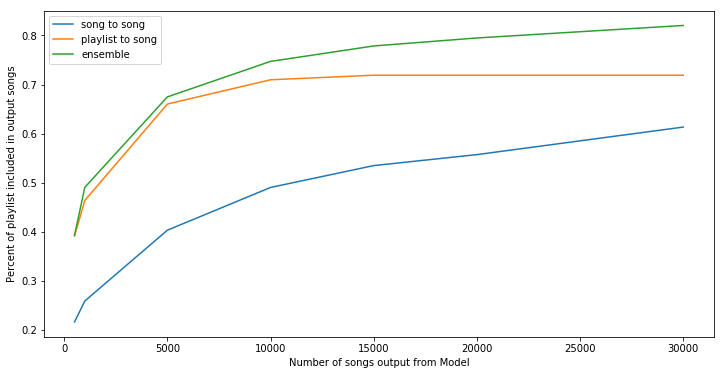

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
x = output_sizes
ax.plot(x, [np.array(v).mean() for v in song_to_song.values()], label='song to song')
ax.plot(x, [np.array(v).mean() for v in playlist_to_song.values()], label='playlist to song')
ax.plot(x, [np.array(v).mean() for v in ensemble.values()], label='ensemble')
ax.legend()

ax.set_xlabel("Number of songs output from Model")
ax.set_ylabel("Percent of playlist included in output songs")

plt.show()

# 2. Extract Features for stage 2

## (2.1) Extract and store features

In [12]:
"""
DO NOT RUN THIS CODE. IT WILL TAKE FOREVER. USE THE STORED PICKLE FILES.
"""
# train_playlists = []
# for i in range(1, 10):
#     filename = f'/Users/mabasta/Desktop/CS109a/playlist-generation/data/Songs/songs{i}.csv'
#     cols_ignore = ['pos', 'artist_name', 'artist_uri', 'track_name', 'album_uri', 'duration_ms', 'album_name']
#     df = pd.read_csv(filename).drop(columns = cols_ignore)
#     train_playlists.extend([group.track_uri for _, group in df.groupby('pid')])

# val_playlists = []
# for i in range(10, 12):
#     filename = f'/Users/mabasta/Desktop/CS109a/playlist-generation/data/Songs/songs{i}.csv'
#     cols_ignore = ['pos', 'artist_name', 'artist_uri', 'track_name', 'album_uri', 'duration_ms', 'album_name']
#     df = pd.read_csv(filename).drop(columns = cols_ignore)
#     val_playlists.extend([group.track_uri for _, group in df.groupby('pid')])

# _, tid_to_idx, _, _, _ = wrmf_helpers.get_user_item_sparse_matrix(PATH_TO_SPARSE_MATRIX)

# """
# Generate train dataset from stage 1 data
# """
# train_dfs = []
# start_time = time.time()
# start = 0
# end = 3000
# for i in range(start, end):
#     try:
#         if len(train_playlists[i]) > 2:
#             train_dfs.append(compute_df(train_playlists[i], song_factors, playlist_factors))
# #             train_dfs.append(compute_df_v2(train_playlists[i])
#     except (KeyError, AttributeError) as e:
#         print(f'Error on playlist{i}. Skipping')

#     current_time = time.time()
#     elapsed_time = current_time - start_time
#     time_left = (end-start) * elapsed_time / float(i+1-start) - elapsed_time
#     sys.stdout.write(
#         f"\rParsed playlist {i+1}. Time elapsed: {str(datetime.timedelta(seconds=elapsed_time))[:-7]}. Time remaining: {str(datetime.timedelta(seconds=time_left))[:-7]}")
#     sys.stdout.flush()

# train_df = pd.concat(train_dfs)

# with open('../data/stage_2_train.pickle', 'wb') as f:
#     pickle.dump(train_df , f)
    

# val_dfs = []
# start_time = time.time()
# start = 0
# end = 100
# for i in range(start, end):
#     try:
#         if len(val_playlists[i]) > 2:
#     #         val_dfs.append(compute_df_v2(val_playlists[i]))
#             val_dfs.append(compute_df(val_playlists[i], song_factors, playlist_factors))
#     except (KeyError, AttributeError) as e:
#         print(f'Error on playlist{i}. Skipping')
#     current_time = time.time()
#     elapsed_time = current_time - start_time
#     time_left = (end-start) * elapsed_time / float(i+1-start) - elapsed_time
#     sys.stdout.write(
#         f"\rParsed playlist {i+1}. Time elapsed: {str(datetime.timedelta(seconds=elapsed_time))[:-7]}. Time remaining: {str(datetime.timedelta(seconds=time_left))[:-7]}")
#     sys.stdout.flush()

# val_df = pd.concat(val_dfs)

# """
# Generate validation dataset from stage 1 data
# """
# with open('../data/stage_2_val.pickle', 'wb') as f:
#     pickle.dump(val_df , f)

'\nDO NOT RUN THIS CODE. IT WILL TAKE FOREVER. USE THE STORED PICKLE FILES.\n'

# 3. Train stage 2 models

In [13]:
with open('data/stage_2_train.pickle', 'rb') as f:
    train_df = pickle.load(f)
with open('data/stage_2_val.pickle', 'rb') as f:
    val_df = pickle.load(f)

In [14]:
ytrain = train_df['relevence']
Xtrain = train_df.drop('relevence', axis=1)

yval = val_df['relevence']
Xval = val_df.drop('relevence', axis=1)

print(Xtrain.shape)
print(ytrain.shape)
print(Xval.shape)
print(yval.shape)

(54592, 16)
(54592,)
(1752, 16)
(1752,)


### Logistic Regression

In [15]:
log_model = LogisticRegressionCV(cv=3).fit(Xtrain, ytrain)

pred_train = log_model.predict(Xtrain)
print("Logistic regression training accuracy: %.2f" % (accuracy_score(ytrain, pred_train) * 100))

pred_val = log_model.predict(Xval)
print("Logistic regression test accuracy: %.2f" % (accuracy_score(yval, pred_val) * 100))

Logistic regression training accuracy: 50.00
Logistic regression test accuracy: 50.00


### Decision Tree w/ CV¶

In [16]:
depths = np.arange(1, 16, 2)
dt_model = GridSearchCV(
    DecisionTreeClassifier(),
    dict(max_depth = depths),
    cv=5,
    return_train_score=True
).fit(Xtrain, ytrain)

pred_train = dt_model.predict(Xtrain)
print("DT training accuracy: %.2f" % (accuracy_score(ytrain, pred_train) * 100))

pred_val = dt_model.predict(Xval)
print("DT test accuracy: %.2f" % (accuracy_score(yval, pred_val) * 100))

DT training accuracy: 63.90
DT test accuracy: 62.04


### XG Boost

In [17]:
xgb_model = xgb.XGBClassifier(n_estimators=150, max_depth=10, learning_rate=0.1, subsample=0.5).fit(Xtrain, ytrain)

pred_train = xgb_model.predict(Xtrain)
print("XG Boost training accuracy: %.2f" % (accuracy_score(ytrain, pred_train) * 100))

pred_val = xgb_model.predict(Xval)
print("XG Boost test accuracy: %.2f" % (accuracy_score(yval, pred_val) * 100))

XG Boost training accuracy: 90.52
XG Boost test accuracy: 69.29


# 4. Test for clicks on witheld playlists

In [18]:
test_playlists = []
for i in range(800, 810):
    filename = f'/Users/mabasta/Desktop/CS109a/playlist-generation/data/Songs/songs{i}.csv'
    cols_ignore = ['pos', 'artist_name', 'artist_uri', 'track_name', 'album_uri', 'duration_ms', 'album_name']
    df = pd.read_csv(filename).drop(columns = cols_ignore)
    test_playlists.extend([group.track_uri for _, group in df.groupby('pid')])

In [21]:
# Logistic Regression 
start = 1
end = 40

log_clicks = []
for i in range(start, end):
    try:
        if len(test_playlists[i]) > 50:
            click_score = get_model_clickscore(test_playlists[i], log_model)
            log_clicks.append(click_score)
    except (KeyError, AttributeError):
        pass

print(pd.Series(log_clicks).mean())
print(pd.Series(log_clicks).median())

44.416666666666664
34.5


In [19]:
# Decision Tree w/ CV test
start = 1
end = 40

dt_clicks = []
for i in range(start, end):
    try:
        if len(test_playlists[i]) > 50:
            click_score = get_model_clickscore(test_playlists[i], dt_model)
            dt_clicks.append(click_score)
    except (KeyError, AttributeError):
        pass

print(pd.Series(dt_clicks).mean())
print(pd.Series(dt_clicks).median())

90.8695652173913
49.0


In [20]:
# XG boost test
start = 1
end = 40

xgb_clicks = []
for i in range(start, end):
    try:
        if len(test_playlists[i]) > 50:
            click_score = get_model_clickscore(test_playlists[i], xgb_model)
            xgb_clicks.append(click_score)
    except (KeyError, AttributeError):
        pass

print(pd.Series(xgb_clicks).mean())
print(pd.Series(xgb_clicks).median())

65.9090909090909
28.0


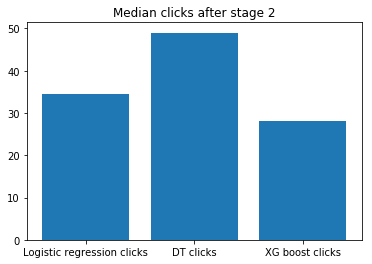

In [25]:
x = ['Logistic regression clicks', 'DT clicks', 'XG boost clicks']
y = [pd.Series(log_clicks).median(), pd.Series(dt_clicks).median(), pd.Series(xgb_clicks).median()]
plt.bar(x, y)
plt.title("Median clicks after stage 2")
plt.show()